# Модель монетизации online-игры

**Цель исследования:** формирование модели монетизации, обеспечивающей окупаемость маркетинговой компании.  

**Заказчик исследования:** маркетинговый отдел компании-разработчика.

**Описание данных**  
Исходные данные:  
В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.  

Таблицы с исходными данными содержится в файлах "game_actions.csv", "ad_costs.csv" и "user_sourse.csv".  


В таблице "game_actions.csv" представлены следующие данные:   

- "event_datetime" — время события;
- "event" — одно из трёх событий:
    1. "building" — объект построен,
    2. "finished_stage_1" — первый уровень завершён,
    3. "project" — проект завершён;
- "building_type" — один из трёх типов здания:
    1. "assembly_shop" — сборочный цех,
    2. "spaceport" — космопорт,
    3. "research_center" — исследовательский центр;
- "user_id" — идентификатор пользователя;
- "project_type" — тип реализованного проекта.

В таблице "ad_costs.csv" представлены следующие данные:   

- "day" - день, в который был совершен клик по объявлению;
- "source" - источник трафика;
- "cost" - стоимость кликов.

В таблице "user_sourse.csv" представлены следующие данные:   

- "user_id" - идентификатор пользователя;
- "source" - источников, с которого пришёл пользователь, установивший приложение.

**Содержание исследования:**  
1. [Общая информация](#open_file) 
2. [Предобработка данных](#data_preprocessing)  

  2.1. [Обработка пропущенных значений](#missing_values)  
  2.2. [Обработка дубликатов](#drop_dupl)  
  2.3. [Оптимизация типов данных](#change_type)  
  2.4. [Обработка выбросов](#handling_emissions)  
  
  
3. [Исследовательский анализ данных](#eda)  
  
  3.1. [Функции расчета](#functions)  
  3.2. [Общий анализ](#general_analysis)  
  3.3. [Анализ по способу завершения первого уровня](#final_stage_analysis)  
  3.4. [Анализ по источникам трафика](#channel_analysis)  
  3.5. [Оптимальные схемы показа рекламы](#schemas) 


4. [Проверка гипотез](#hypotheses)  
5. [Общий вывод](#final)  
  - [Рекомендации](#recom)  

## Общая информация
<a id="open_file"></a>

**Импорт библиотек**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime, timedelta
from urllib.parse import urlencode
import matplotlib.ticker as ticker
from scipy import stats as st
from scipy.stats import levene
from matplotlib import rcParams

**Создание датафреймов**

In [2]:
def read_table(linc):
    '''функция загрузки таблиц по ссылке'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = linc

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    pd.read_csv(download_url) 
    return pd.read_csv(download_url)

In [3]:
try:
    df_costs_start = read_table('https://disk.yandex.ru/d/PjE2POcSyDSoVQ')
except:
    df_costs_start = pd.read_csv('../ad_costs.csv')
    
try:
    df_actions_start = read_table('https://disk.yandex.ru/d/d0326TvVybgbVQ')
except:
    df_actions_start = pd.read_csv('../game_actions.csv')
    
try:
    df_sourse_start = read_table('https://disk.yandex.ru/d/VlmspW1CYuC8Lg')
except:
    df_sourse_start = pd.read_csv('../user_source.csv')

pd.set_option('display.max_columns', None)

**Общая информация о датафреймах**

In [4]:
def inf(df_tmp):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df_tmp.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df_tmp.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df_tmp.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество дубликатов:')
    print(df_tmp.duplicated().sum())
    print('_' * 50)  
    print()
    print('Описательная статистика строковых значений:')
    display(df_tmp.describe(include=['object']).T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_tmp.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df_tmp.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df_tmp.isna().mean()*100)  

**Общая информация о датафрейме "df_costs_start"**

In [5]:
inf(df_costs_start)

Размер датафрейма:
(28, 3)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 4.2 KB
None
__________________________________________________

Несколько строк датафрейма:


,source,day,cost
2,facebook_ads,2020-05-05,260.185754
22,youtube_channel_reklama,2020-05-04,259.073224
14,yandex_direct,2020-05-03,969.139394
17,yandex_direct,2020-05-06,180.917099
5,facebook_ads,2020-05-08,68.009276


__________________________________________________

Количество дубликатов:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
source,28,4,facebook_ads,7
day,28,7,2020-05-08,4


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
cost,28.0,271.556321,286.86765,23.314669,66.747365,160.056443,349.034473,969.139394


__________________________________________________

Количество пропусков:
source    0
day       0
cost      0
dtype: int64

Количество пропусков в процентах:
source    0.0
day       0.0
cost      0.0
dtype: float64


**Общая информация о датафрейме "df_actions_start"**

In [6]:
inf(df_actions_start)

Размер датафрейма:
(135640, 5)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 43.1 MB
None
__________________________________________________

Несколько строк датафрейма:


,event_datetime,event,building_type,user_id,project_type
126283,2020-05-18 19:01:56,building,spaceport,8baf4ab0-f490-4642-b68f-5f4a2826c458,NaN
5087,2020-05-04 15:12:32,building,assembly_shop,fb7febbc-8cbb-4c11-8cee-5f56226177c4,NaN
43899,2020-05-08 11:48:13,building,spaceport,369e2d01-7249-486c-b8f5-de67045df492,NaN
56075,2020-05-09 11:25:18,building,spaceport,f44f5682-781d-465e-aba0-a8431d1d2380,NaN
45270,2020-05-08 14:36:36,building,assembly_shop,4468b134-087c-4fda-9ef0-347c20db0b18,NaN


__________________________________________________

Количество дубликатов:
1
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
event_datetime,135640,128790,2020-05-04 04:02:30,4
event,135640,3,building,127957
building_type,127957,3,spaceport,59325
user_id,135640,13576,bf542075-e3a2-4e79-82d8-3838e86d2a25,22
project_type,1866,1,satellite_orbital_assembly,1866


__________________________________________________

Описательная статистика числовых значений:


,count,unique,top,freq
event_datetime,135640,128790,2020-05-04 04:02:30,4
event,135640,3,building,127957
building_type,127957,3,spaceport,59325
user_id,135640,13576,bf542075-e3a2-4e79-82d8-3838e86d2a25,22
project_type,1866,1,satellite_orbital_assembly,1866


__________________________________________________

Количество пропусков:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Количество пропусков в процентах:
event_datetime     0.000000
event              0.000000
building_type      5.664258
user_id            0.000000
project_type      98.624300
dtype: float64


**Общая информация о датафрейме "df_sourse_start"**

In [7]:
inf(df_sourse_start)

Размер датафрейма:
(13576, 2)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 2.2 MB
None
__________________________________________________

Несколько строк датафрейма:


,user_id,source
6038,70add26e-414d-4620-8ae6-13966c0234f9,facebook_ads
4247,4e316ad8-edf0-43cc-9026-33a0916facb0,yandex_direct
2861,3405417c-88d6-4d91-ad73-4cd46375cea7,yandex_direct
7423,8ae2b622-33ca-4818-951b-db0fa7a92c91,instagram_new_adverts
7150,85309d96-580c-4e7a-968e-1cf0ed66158f,youtube_channel_reklama


__________________________________________________

Количество дубликатов:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
user_id,13576,13576,ccbfae4d-6566-400f-ac78-e31e07545169,1
source,13576,4,yandex_direct,4817


__________________________________________________

Описательная статистика числовых значений:


,count,unique,top,freq
user_id,13576,13576,ccbfae4d-6566-400f-ac78-e31e07545169,1
source,13576,4,yandex_direct,4817


__________________________________________________

Количество пропусков:
user_id    0
source     0
dtype: int64

Количество пропусков в процентах:
user_id    0.0
source     0.0
dtype: float64


**Вывод:**
1. Датафрейм "df_costs_start":

  - в датафрейме 28 строк и 3 столбца;
  - значения "source" и "day" имеют тип "object"; значения "cost" имеют тип "float64";
  - дубликаты отсутствуют;
  - пропуски отсутствуют.
  
2. Датафрейм "df_actions_start":

  - в датафрейме 135640 строк и 5 столбцов;
  - все значения имеют тип "object";
  - присутствует один дубликат;
  - в столбце "building_type" пропущено 7683 значения, в столбце "project_type" - 133774 значения.
  
3. Датафрейм "df_sourse_start":

  - в датафрейме 135640 строк и 5 столбцов;
  - все значения имеют тип "object";
  - дубликаты отсутствуют;
  - пропуски отсутствуют.

## Предобработка данных
<a id="data_preprocessing"></a>

Создаем копии исходных датафреймов:

In [8]:
df_costs = df_costs_start.copy()
df_actions = df_actions_start.copy()
df_sourse = df_sourse_start.copy()

### Обработка пропущенных значений
<a id="missing_values"></a>

**Тип построек ("building_type")**

Выводим уникальные значения событий ("event"):

In [9]:
df_actions.loc[df_actions['building_type'].isna()]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

Поле "building_type" заполняется только при наступлении события "постройка", то есть, когда в поле "event" указано значение "building". Для прочих событий тип постройки не указывается в виду ее (постройки) отсутствия. Оставляем пропуски.

**Тип реализованного проекта ("project_type")**

In [10]:
df_actions.loc[df_actions['project_type'].isna()]['event'].unique()

array(['building', 'finished_stage_1'], dtype=object)

Поле "project_type" заполняется только при наступлении события "реализация проекта", то есть, когда в поле "event" указано значение "project". Для прочих событий тип проекта не указывается в виду его (проекта) отсутствия. Оставляем пропуски.

### Обработка дубликатов
<a id="drop_dupl"></a>

В датафрейме "df_actions" присутствует один дубликат. Удаляем его.

In [11]:
df_actions = df_actions.drop_duplicates().reset_index(drop=True)

### Оптимизация типов данных
<a id="change_type"></a>

**Датафрейм "df_costs"**

Типы значений источников трафика ("source") и стоимости кликов ("cost") в преобразовании не нуждаются. Требуется изменить тип значений даты, когда был совершен клик по объявлению, с "object" на "datetime".
Выводим уникальные значения поля "day":

In [12]:
df_costs['day'].unique()

array(['2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
       '2020-05-07', '2020-05-08', '2020-05-09'], dtype=object)

Диапазон дат, представленных в датафрейме - с 2020-05-03 по 2020-05-09. При этом в ТЗ указано, что проводится исследование на основании данных о пользователях, зарегистрированных с 2020-05-04 по 2020-05-10. Смещение по датам связано с тем, что привлечение клиентов оплачивалось авансом, накануне.  
Помимо изменения типа поля "day" избавляемся от смещения по дате:

In [13]:
df_costs['day'] = pd.to_datetime(df_costs['day'], format='%Y-%m-%d') + pd.Timedelta(days=1)

**Датафрейм "df_actions"**

Значения событий ("event"), типов зданий ("building_type"), идентификаторов пользователей ("user_id") и типов реализованных проектов ("project_type") имеют тип "object" и в преобразовании не нуждаются.  
Изменяем тип значений времени событий ("event_datetime") с "object" на "datetime":ьь

In [14]:
df_actions['event_datetime'] = pd.to_datetime((pd.to_datetime(df_actions['event_datetime']).dt.date), format='%Y-%m-%d')

Выводим уникальные значения времени событий ("event_datetime"):

In [15]:
df_actions['event_datetime'].unique()

array(['2020-05-04T00:00:00.000000000', '2020-05-05T00:00:00.000000000',
       '2020-05-06T00:00:00.000000000', '2020-05-07T00:00:00.000000000',
       '2020-05-08T00:00:00.000000000', '2020-05-09T00:00:00.000000000',
       '2020-05-10T00:00:00.000000000', '2020-05-11T00:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-05-13T00:00:00.000000000',
       '2020-05-14T00:00:00.000000000', '2020-05-15T00:00:00.000000000',
       '2020-05-16T00:00:00.000000000', '2020-05-17T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-19T00:00:00.000000000',
       '2020-05-20T00:00:00.000000000', '2020-05-21T00:00:00.000000000',
       '2020-05-22T00:00:00.000000000', '2020-05-23T00:00:00.000000000',
       '2020-05-24T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
       '2020-05-26T00:00:00.000000000', '2020-05-27T00:00:00.000000000',
       '2020-05-28T00:00:00.000000000', '2020-05-29T00:00:00.000000000',
       '2020-05-30T00:00:00.000000000', '2020-05-31

Начальная дата - 2020-05-04 - совпадает с указанной в ТЗ.

**Датафрейм "df_sourse"**

Значения идентификаторов пользователей ("user_id") и источников трафика ("source") имеют тип "object" и в преобразовании не нуждаются.

### Обработка выбросов
<a id="handling_emissions"></a>

Числовое значение имеют только данные по стоимости клика ("cost") датафрейма "df_costs".
Выводим датафрейм "df_costs":

In [16]:
df_costs

,source,day,cost
0,facebook_ads,2020-05-04,935.882786
1,facebook_ads,2020-05-05,548.354480
2,facebook_ads,2020-05-06,260.185754
3,facebook_ads,2020-05-07,177.982200
4,facebook_ads,2020-05-08,111.766796
5,facebook_ads,2020-05-09,68.009276
6,facebook_ads,2020-05-10,38.723350
7,instagram_new_adverts,2020-05-04,943.204717
8,instagram_new_adverts,2020-05-05,502.925451
9,instagram_new_adverts,2020-05-06,313.970984


В виду небольшого количества данных (всего 28) и схожести значений стоимости клика для разных источников трафика, принимаем их как надежными в плане отсутствия выбросов.

**Вывод:**  
1. Удалены дубликаты.
2. Оптимизация типов данных: даты приведены к типу "datetime64".
3. Устранено смещение по дате в данных о затратах на маркетинг.

## Исследовательский анализ данных
<a id="eda"></a>

### Функции расчета
<a id="functions"></a>

In [17]:
def pie_plot(df, field):
    '''отрисовка круговых диаграмм'''
    
    # создаем таблицу со значениями

    display(df.groupby(field)['user_id'].nunique())
    
    # создаем круговую диаграмму
    label = {
        'win_type' : 'пользователей по способу завершения первого уровня',
        'building_type' : 'построенных зданий по типам',
        'source' : 'пользователей по источникам трафика',
        'first_stage_finish' : 'завершивших первый этап'
    }
    plt.figure(figsize=(10,10))
    df = df.groupby(field)['user_id'].nunique()
    plt.pie(
        x=df,
        labels=df.groupby(field).nunique().index,
        autopct='%1.1f%%'
    )
    plt.title(f'Процент {label.get(field)}', fontsize=(15))
    plt.show()

In [18]:
def dau(df, field=[]):
    '''Функция расчёта и отрисовки dau'''
    plt.figure(figsize=(14,8))
    if field == []:
        df_dau = df.pivot_table(index=['first_event_date'], values='user_id', aggfunc='nunique').reset_index()
        display(df_dau)
        sns.lineplot(x = "first_event_date", y = "user_id", data = df_dau, marker = 'o')
    else:
        df_dau = df.pivot_table(index=['source', 'first_event_date'], values='user_id', aggfunc='nunique').reset_index()
        display(df_dau)
        sns.lineplot(x = "first_event_date", y = "user_id", hue='source', data = df_dau, marker = 'o')
    plt.title('Регистраций в день', fontsize=17)
    plt.xlabel('Дней', fontsize = 15)
    plt.ylabel('Регистраций', fontsize = 15)
    plt.xticks(rotation=45);

In [19]:
def get_profiles(df):
    '''создание профилей пользователей для расчёта LTV, CAS и ROI.
       Создает таблицу, содержащую id пользователя, дату первого события,
       канал и стоимость привлечения для каждого уникального пользователя.'''
    
    # определяем дату и канал привлечения
    df_profiles = (
        df
            .groupby('user_id').agg({'first_event_date' : 'first',
                                     'source' : 'first',
                                     'win_type' : 'first',
                                     'cost_invitation' : 'first'})
            .reset_index()
    )
    return df_profiles

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    observation_date,
    horizon_days,
    field=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_event_date <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = (
        result_raw
            .merge(df_actions.loc[df_actions['event'] == 'building'], on='user_id', how='left')
            .assign(price = 0.07)
            .sort_values(by=['user_id', 'event_datetime'])
    )
    result_raw['serial'] = result_raw.groupby('user_id').cumcount() + 1
    return result_raw
    


def roi_calculation(result_raw, field, horizon_days):
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_event_date']
    ).dt.days
    # группируем по cohort, если в field ничего нет
    if len(field) == 0:
        result_raw['cohort'] = 'All users'
        field = field + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_field(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='price', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из field
        cac = df[['user_id', 'cost_invitation'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из field
        cac = (
            cac.groupby(dims)
            .agg({'cost_invitation': 'mean'})
            .rename(columns={'cost_invitation': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_field(
        result_raw, field, horizon_days
    )

# # для таблиц динамики убираем 'cohort' из field
    if 'cohort' in field:
        field = []

# # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_field(
        result_raw, field + ['first_event_date'], horizon_days
    )
        
        
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [21]:
def event_iteration(
    profiles,
    observation_date,
    horizon_days,
    field=[],
    ignore_horizon=False,
):
    
    result_raw = get_ltv(profiles, observation_date, horizon_days, field=field)
    iteration_list=[]
    values_list = []
    iteration_number = 0
    build_number = df_actions.loc[df_actions['event'] == 'building'].groupby('user_id')['event'].count().max()
    for i in range(0, build_number):
        iteration_number += 1
        result_raw.loc[result_raw['serial'] == i, 'price'] = 0
        result_raw_tmp, result_grouped, result_in_time, roi_grouped, roi_in_time = roi_calculation(
            result_raw, field, horizon_days
        )
        iteration_list.append(iteration_number)
        values_list.append(roi_grouped.iloc[0,-1])
    result_raw = result_raw_tmp
    df_iterations = pd.DataFrame({'iteration': iteration_list, 'roi_last': values_list})
    
    # отрисовка графика
    fig, ax = plt.subplots(figsize=(14,10))
    sns.barplot(data=df_iterations, x='iteration', y='roi_last', color='skyblue', ax=ax)
    ax.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    ax.legend()
    ax.set_title('ROI в последние день горизонта событий в зависимости от порядкового номера постройки, с которого стартует показ рекламы', fontsize=17)
    ax.set_xlabel('Порядковый номер постройки', fontsize = 15)
    ax.set_ylabel('ROI на последний день горизонта анализа', fontsize = 15)

In [22]:
def ltv_roi(
    profiles,
    observation_date,
    horizon_days,
    field = [],
    dbt = '',
    ignore_horizon=False,
):
    result_raw = get_ltv(profiles, observation_date, horizon_days, field=field)
    if dbt != '':
        result_raw.loc[result_raw['building_type'] == dbt, 'price'] = 0
    result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = roi_calculation(
            result_raw, field, horizon_days
        )

    return (
            result_raw,  # сырые данные
            result_grouped,  # таблица LTV
            result_in_time,  # таблица динамики LTV
            roi_grouped,  # таблица ROI
            roi_in_time,  # таблица динамики ROI
        )

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):
    '''функция для визуализации LTV и ROI'''

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, marker = 'o', ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['first_event_date']]
    filtered_data = ltv_history.pivot_table(
        index='first_event_date', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filtered_data.plot(grid=True, marker = 'o', ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['first_event_date']]
    filtered_data = cac_history.pivot_table(
        index='first_event_date', columns=columns, values='cac', aggfunc='mean'
    )
    filtered_data.plot(grid=True, marker = 'o', ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, marker = 'o', ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['first_event_date']]
    filtered_data = roi_history.pivot_table(
        index='first_event_date', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filtered_data.plot(grid=True, marker = 'o', ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
def build_per_user(df, field):
    df_mean = (
        df
            .loc[df['event'] == 'building'].groupby('user_id')
            .agg({field[0] : 'first', 'event' : 'count'})
            .groupby(field[0])['event']
            .mean()
            .reset_index()
            .sort_values(by='event')
            .reset_index(drop=True)
    )
    display(df_mean)

    plt.figure(figsize=(14,10))
    ax = plt.bar(df_mean[field[0]], df_mean['event'])
    plt.title('Среднее количество строений')
    plt.ylabel('Строений')
    plt.xlabel('Способ завершения первого этапа')
#    lmt = (df_mean['event'].max() - df_mean['event'].min())*0.2
#    plt.ylim([df_mean['event'].min() - lmt, df_mean['event'].max() + lmt])
    plt.show()

### Общий анализ
<a id="general_analysis"></a>

Доход от показа рекламы - 0.07$:

In [25]:
advertisement = 0.07

**Объединение таблиц**

Объединяет дататафреймы:

In [26]:
# объединяем данные по действиям пользователей с данными по источникам трафика
df_work = df_actions.merge(df_sourse, how='left', left_on='user_id', right_on='user_id')

# определяем даты первого и последнего действия, и жизненный цикл пользователя
df_first_last_date = df_work.groupby(['user_id']).agg(first_event_date = ('event_datetime', 'min'), last_event_date = ('event_datetime', 'max')).reset_index()
df_work = df_work.merge(df_first_last_date, how='left', on='user_id')
df_work['first_event_date'] = pd.to_datetime(df_work['first_event_date'])    # дата привлечения
df_work['last_event_date'] = pd.to_datetime(df_work['last_event_date'])      # дата последнего действия

# объединяем данные по действиям пользователей и источникам трафика с данными по стоимости привлечения клиентов
df_work = df_work.merge(df_costs, left_on=['first_event_date', 'source'], right_on=['day', 'source'], how='left')

**Расчёт и добавление в датафрейм дополнительных параметров**

***- Время прохождения первого уровня***

Рассчитываем время прохождения первого уровня как разницу даты завершения уровня и даты первого события. Пропуски заменяем на "-1", а тип значений на "int":

In [27]:
df_work.loc[df_work['event'] == 'finished_stage_1', 'stage_time'] = (df_work['event_datetime'] - df_work['first_event_date']).dt.days
df_work['stage_time'] = df_work['stage_time'].fillna(-1).astype(int)

***- Способы завершения первого этапа***

Пользователей, закончивших первый уровень посредством завершения проекта, определяем по значению "satellite_orbital_assembly" в поле "project_type". Остальные пользователи, закончившие первый уровень, - завершили этап победой над соперником.  
Создаем таблицу с данными пользователей, завершивших первый этап:

In [28]:
df_winner = (
    df_work
        .loc[df_work['event'] == 'finished_stage_1'][['user_id']]
        .drop_duplicates(subset={'user_id'})
        .merge(df_work.loc[df_work['project_type'] == 'satellite_orbital_assembly'][['user_id', 'project_type']], on='user_id', how='left')
        .rename(columns={'project_type' : 'project_type_user'})
)
df_winner.loc[df_winner['project_type_user'].notna(), 'win_type'] = 'project_win'
df_winner.loc[df_winner['project_type_user'].isna(), 'win_type'] = 'battle_win'

Добавляем данные по способу завершения первого этапа в общую таблицу:

In [29]:
df_work = df_work.merge(df_winner, on='user_id', how='left')
df_work['win_type'] = df_work['win_type'].where(df_work['win_type'].notna(), 'no_win')

***- Признак окончания первого уровня***

In [30]:
df_work.loc[df_work['win_type'] == 'no_win', 'first_stage_finish'] = 'no_finished'
df_work['first_stage_finish'] = df_work['first_stage_finish'].fillna('finished')

***- Доход от показа рекламы***

Добавляем значения стоимости рекламы для событий, имеющих значения "building":

In [31]:
df_work.loc[df_work['event'] == 'building', 'price_per_building'] = advertisement

***- Стоимость привлечения каждого пользователя***

Добавляем в таблицу значения стоимости привлечения клиентов:

In [32]:
df_work = (
    df_work
        .merge(df_work.groupby(['first_event_date', 'source']).agg({'user_id' : 'nunique'})
               .rename(columns={'user_id' : 'users_cnt'}), on=['first_event_date', 'source'], how='left')
        .assign(cost_invitation=lambda x: x['cost'] / x['users_cnt'])
        .drop(['users_cnt'], axis=1)
)

**Общее распределение пользователей по способу завершения первого уровня**

Строим круговую диаграмму распределения пользователей по способу завершения первого уровня на основе общих данных:

first_stage_finish
finished       5817
no_finished    7759
Name: user_id, dtype: int64

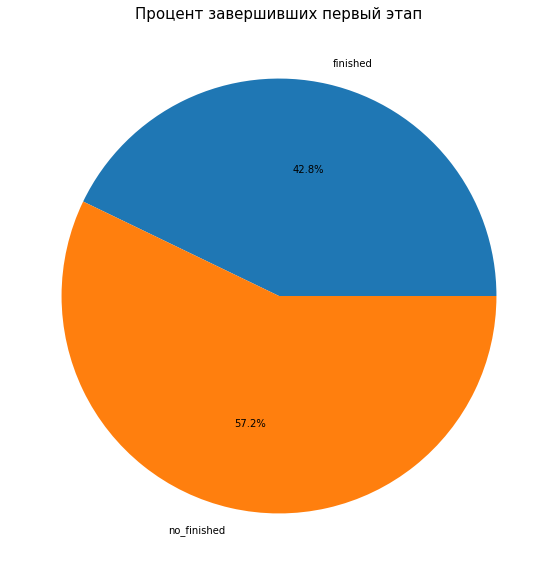

In [33]:
field = 'first_stage_finish'
pie_plot(df_work, field)

Выводы по круговой диаграмме:
- не завершили первый этап - 57.2% (7759) пользователей;
- завершили первый этап - 42.8% (5817) пользователей.

**Количество построенных зданий по типам**

Рассчитываем количество построенных зданий по типам и строим круговую диаграмму:

building_type
assembly_shop      13576
research_center     7671
spaceport          13231
Name: user_id, dtype: int64

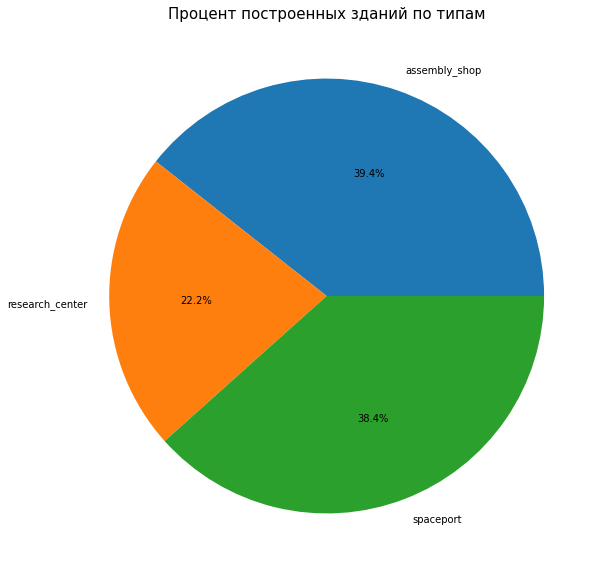

In [34]:
field = 'building_type'
pie_plot(df_work, field)

- процент зданий типа "сборочный цех" ("assembly_shop") - 39.4% (13576);
- процент зданий типа "космопорт" ("spaceport") - 38.4% (13231);
- процент зданий типа "исследовательский центр" ("research_center") - 22.2% (7671).

**Среднее количество зданий на пользователя**

In [35]:
print('Среднее количество зданий на пользователя - {:.2f}'
      .format(df_work.loc[df_work['event'] == 'building']['user_id'].count() / df_work['user_id'].nunique()))

Среднее количество зданий на пользователя - 9.43


**Метрика DAU**

Рассчитываем DAU по общим данным:

,first_event_date,user_id
0,2020-05-04,5860
1,2020-05-05,3361
2,2020-05-06,1847
3,2020-05-07,1109
4,2020-05-08,688
5,2020-05-09,440
6,2020-05-10,271


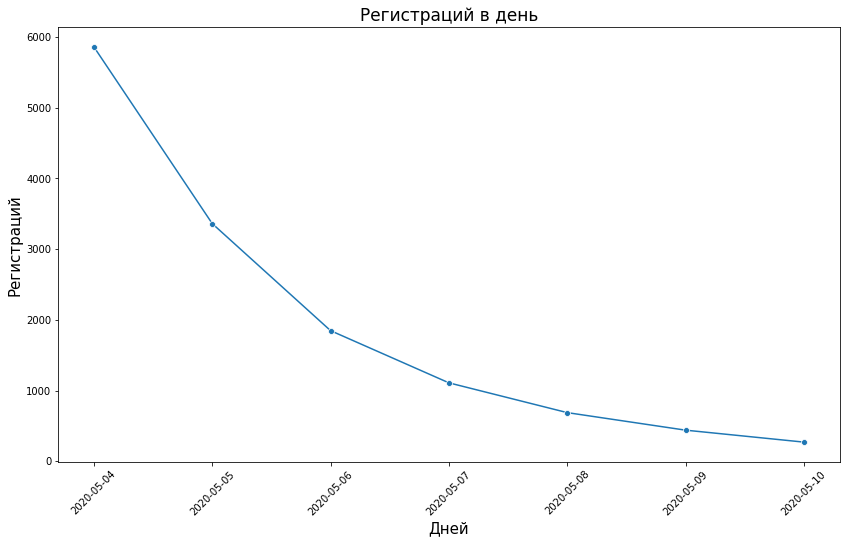

In [36]:
dau(df_work)

Количество привлеченных за сутки уникальных пользователей с 04-05-2020 по 10-05-2020 снижается с 5860 до 271.

**Затраты на привлечение клиентов по дням**

Строим график затрат на привлечение клиентов по дням:

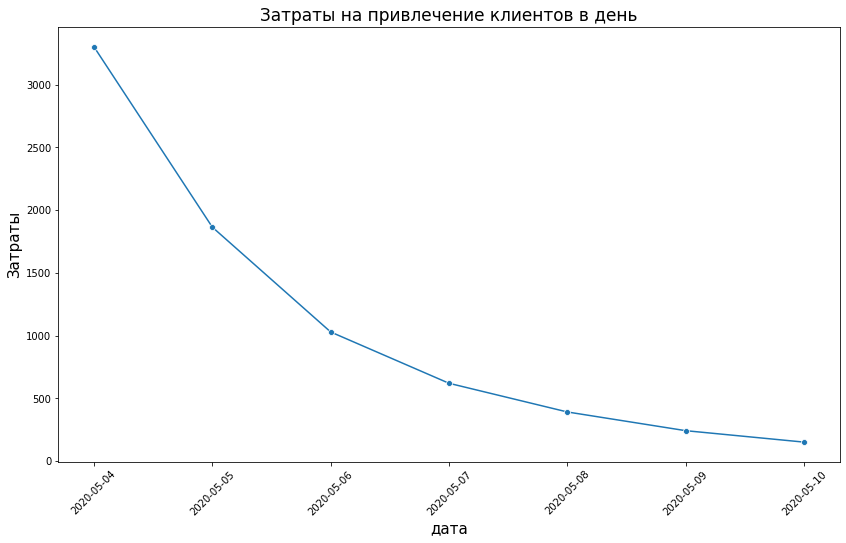

In [37]:
plt.figure(figsize=(14,8))
sns.lineplot(
    x = 'first_event_date',
    y = 'cost',
    data = (
        df_work
            .groupby(['source', 'first_event_date'])['cost'].first()
            .reset_index()
            .groupby('first_event_date')['cost'].sum()
            .reset_index()
    ),
    marker = 'o'
)
      
plt.title('Затраты на привлечение клиентов в день', fontsize=17)
plt.xlabel('дата', fontsize = 15)
plt.ylabel('Затраты', fontsize = 15)
plt.xticks(rotation=45);

Общие затраты за сутки на привлечение пользователей с 04-05-2020 по 10-05-2020 снижается с 3302 до 152.

**LTV, CAC, ROI по всем пользователям**

Задаем момент анализа, определяем горизонт анализа как количество дней, прошедших с последнего дня регистрации пользователей (10.05.2020) до дня последнего события:

In [38]:
observation_date = df_work['last_event_date'].max().date() + pd.Timedelta(days=1)  # момент анализа
horizon_days = (df_work['last_event_date'].max().date() - datetime(2020, 5, 10).date()).days   # горизонт анализа 
print(f'Момент анализа - {observation_date}.')
print(f'Горизонт анализа - {horizon_days} дней.')

Момент анализа - 2020-06-06.
Горизонт анализа - 26 дней.


Создаем таблицу профилей для всех пользователей:

In [39]:
profiles = get_profiles(df_work)

Рассчитываем общие LTV, CAC, ROI и строим графики:

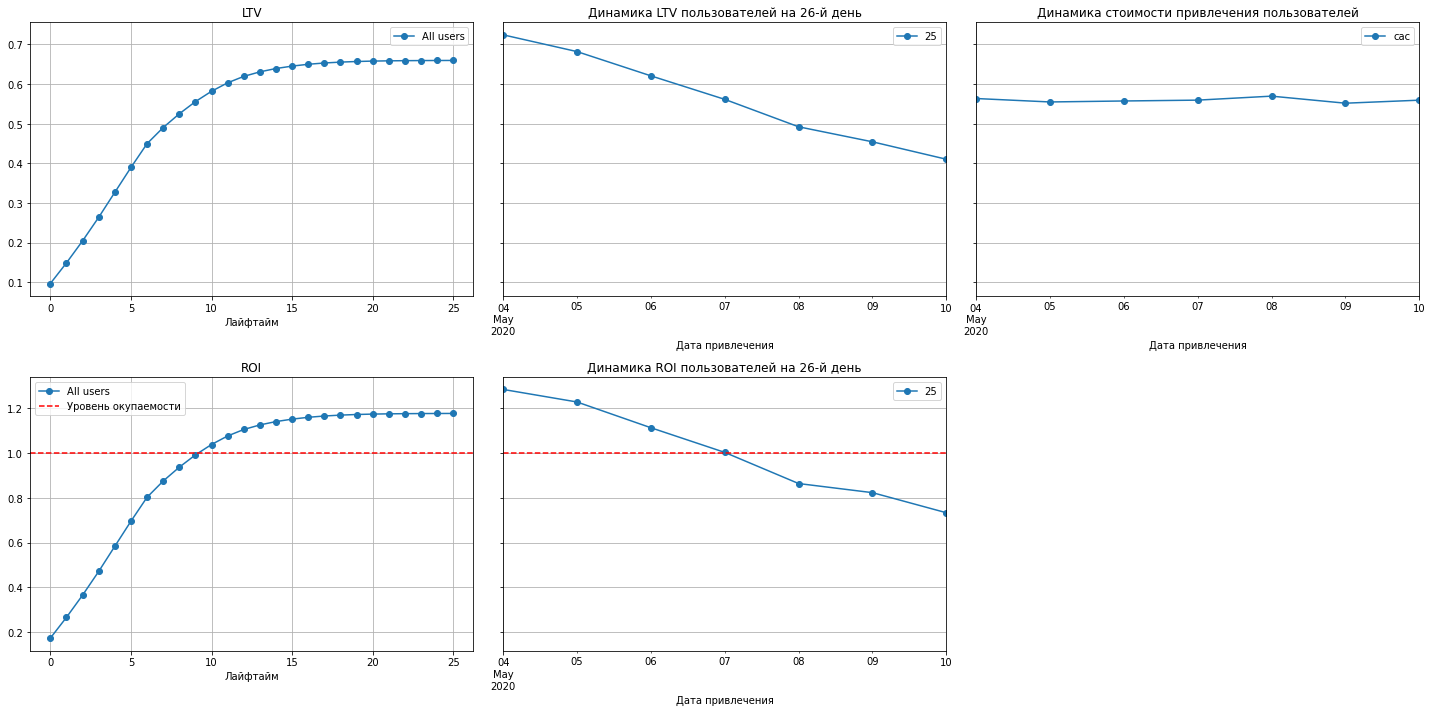

ROI по дням жизненного цикла:


,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,
All users,13576,0.560075,0.17315,0.266068,0.365311,0.471357,0.583756,0.695749,0.802854,0.875389,0.937329,0.992197,1.038799,1.076977,1.105903,1.126249,1.141338,1.152137,1.160422,1.166167,1.170153,1.172915,1.174747,1.175916,1.176616,1.177141,1.177435,1.177665


In [40]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = ltv_roi(
    profiles, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
print('ROI по дням жизненного цикла:')
roi_grouped

- LTV активно растет в первые 2 недели жизненного цикла пользователя;
- CAC в рассматриваемый период меняется незначительно;
- Затраты на привлечение окупаются на 10 день жизненного цикла: ROI превышает единицу.

### Анализ по способу завершения первого уровня 
<a id="final_stage_analysis"></a>

Получаем данные пользователей, завершивших первый этап:

In [41]:
df_stage_finish = df_work.loc[df_work['first_stage_finish'] == 'finished']

**Количество пользователей по способу завершения первого уровня**

win_type
battle_win     3951
project_win    1866
Name: user_id, dtype: int64

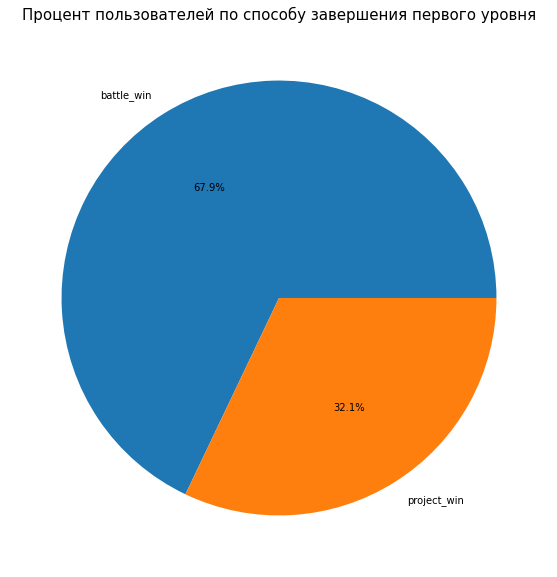

In [42]:
field = 'win_type'
pie_plot(df_stage_finish, field)

Чаще пользователи завершают первый уровень победой над соперником - 67.9% (3951).  
Реализацией проекта завершают первый уровень пользователей - 32.1% (1866).

**Время, затраченное на прохождения первого уровня**

Строим гистограмму распределения времени, затраченного на завершение первого уровня, в зависимости от способа прохождения:

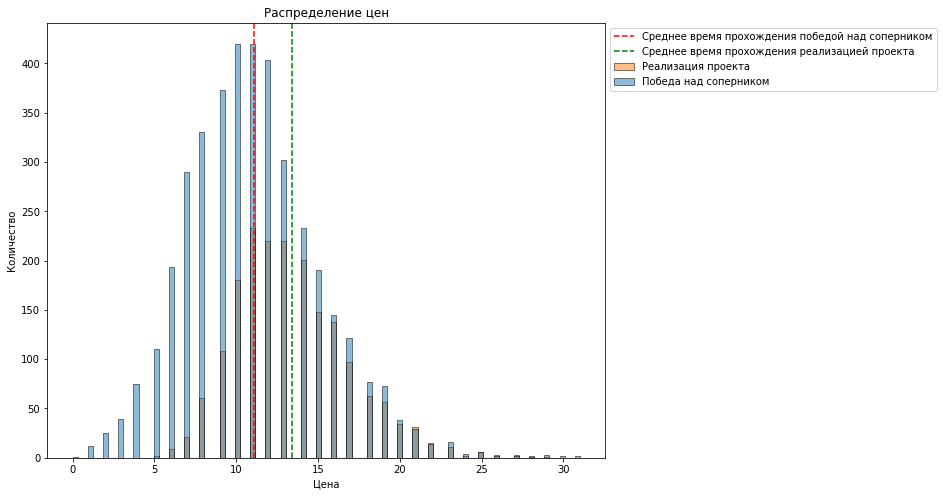

In [43]:
rcParams['figure.figsize'] = 10,8
ax = sns.histplot(
    x='stage_time',
    data=df_stage_finish.loc[df_stage_finish['event'] == 'finished_stage_1'],
    bins=100,
    hue='win_type'
)

ax.axvline(x=df_stage_finish
           .loc[(df_stage_finish['event'] == 'finished_stage_1') & (df_stage_finish['win_type'] == 'battle_win')]['stage_time'].mean(),
           color='red',
           linestyle='--'
          )
ax.axvline(x=df_stage_finish
           .loc[(df_stage_finish['event'] == 'finished_stage_1') & (df_stage_finish['win_type'] == 'project_win')]['stage_time'].mean(),
           color='green',
           linestyle='--', 
           label='Уровень окупаемости')
#ax.legend()
ax.legend(labels=["Среднее время прохождения победой над соперником","Среднее время прохождения реализацией проекта", "Реализация проекта", "Победа над соперником"], loc = 2, bbox_to_anchor = (1,1))
ax.set_title('Распределение цен')
ax.set_ylabel('Количество')
ax.set_xlabel('Цена')


plt.show()

Среднее время прохождения уровня посредством реализации проекта -13.4 дня.  
Среднее время прохождения уровня посредством победы над соперником -11.0 дней.  

**Количество построенных зданий по типам**

***- Количество построенных зданий пользователями, завершившими первый этап победой над соперником***

Рассчитываем количество построенных зданий пользователями, завершившими первый этап победой над соперником, и строим круговую диаграмму:

building_type
assembly_shop      3951
research_center    2342
spaceport          3894
Name: user_id, dtype: int64

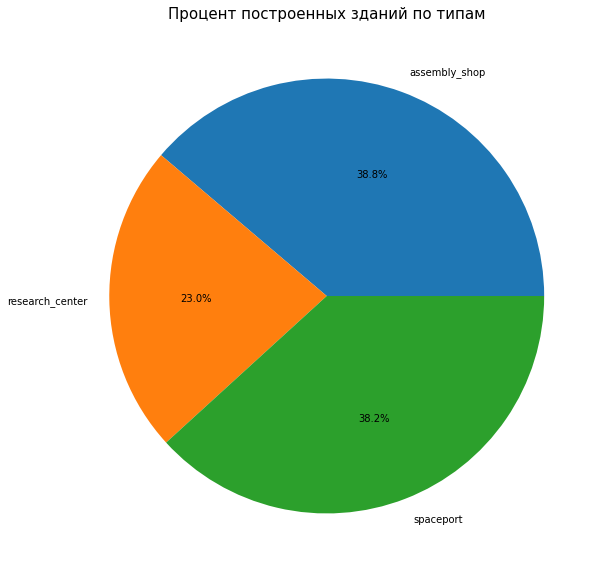

In [44]:
field = 'building_type'
pie_plot(df_stage_finish.loc[df_stage_finish['win_type'] == 'battle_win'], field)

- процент зданий типа "сборочный цех" ("assembly_shop")  - 38.8% (3951);
- процент зданий типа "космопорт" ("spaceport") - 38.2% (3894);
- процент зданий типа "исследовательский центр" ("research_center" ) - 23.0% (2342).

**Количество построенных зданий пользователями, завершившими первый этап реализацией проекта**

Рассчитываем количество построенных зданий пользователями, завершившими первый этап реализацией проекта, и строим круговую диаграмму:

building_type
assembly_shop      1866
research_center    1866
spaceport          1866
Name: user_id, dtype: int64

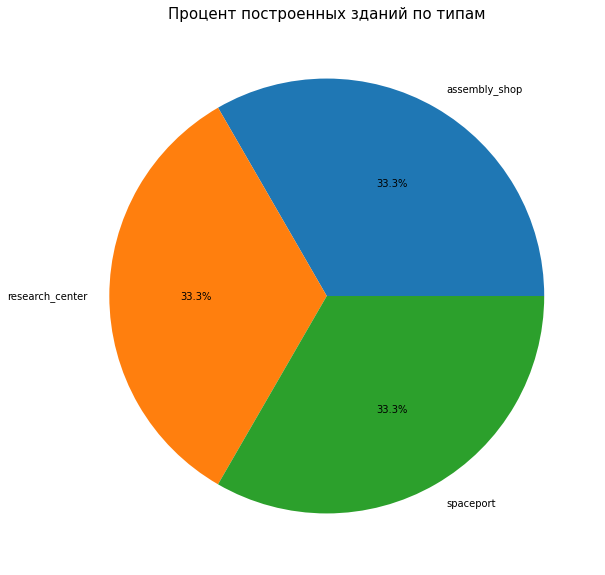

In [45]:
field = 'building_type'
pie_plot(df_stage_finish.loc[df_stage_finish['win_type'] == 'project_win'], field)

- процент зданий типа "космопорт" ("spaceport") - 33.3% (1866);
- процент зданий типа "сборочный цех" ("assembly_shop") - 33.3% (1866);
- процент зданий типа "исследовательский центр" ("research_center" ) - 33.3% (1866).

Группа пользователей, закончивших этап реализацией проекта, в процентном отношении строит больше зданий типа "исследовательский центр" ("research_center" ), нежели группа победивших соперника.

**Среднее количество зданий на пользователя**

Рассчитываем среднее значение количество построенных зданий для каждой группы:

,win_type,event
0,battle_win,9.411541
1,project_win,12.647910


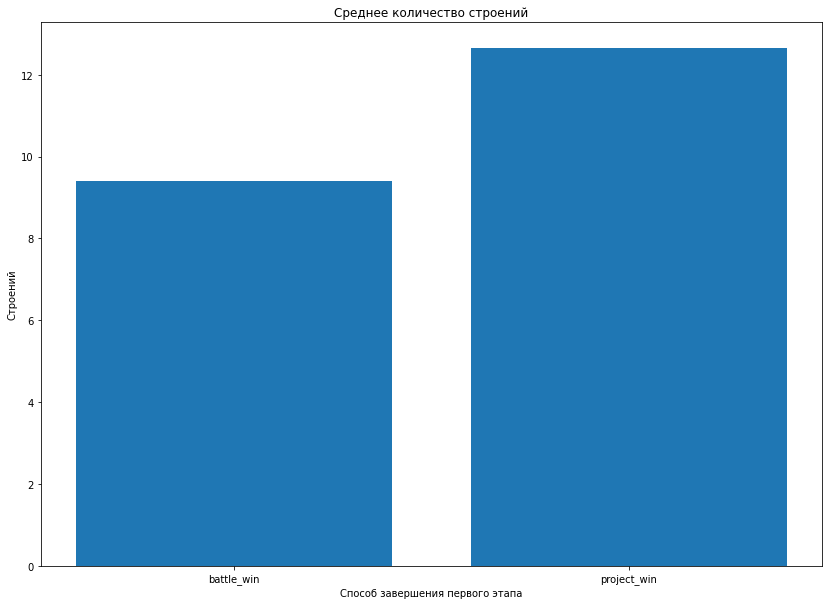

In [46]:
field = ['win_type']
build_per_user(df_stage_finish, field)

В среднем пользователи, закончившие этап реализацией проекта, строят на 3 здания больше, чем закончившие этап победой над соперником.

**Метрика DAU**

Рассчитываем DAU для пользователей, завершивших первый этап:

,first_event_date,user_id
0,2020-05-04,2670
1,2020-05-05,1513
2,2020-05-06,771
3,2020-05-07,412
4,2020-05-08,235
5,2020-05-09,134
6,2020-05-10,82


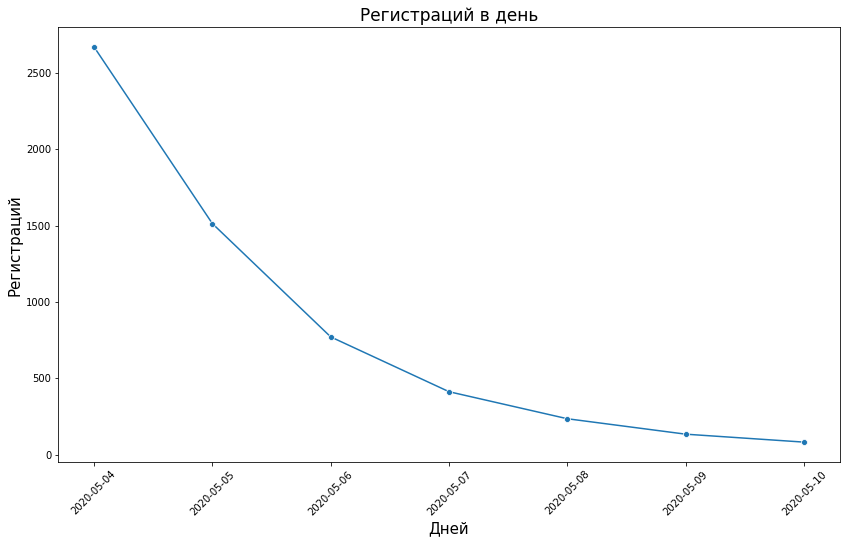

In [47]:
dau(df_stage_finish)

Количество привлеченных за сутки уникальных пользователей, которые завершили первый этап, с 04-05-2020 по 10-05-2020 снижается с 2670 до 82.

**LTV, CAC, ROI по пользователям, завершившим первый этап**

Создаем таблицу профилей пользователей, завершивших первый этап:

In [48]:
profiles_stage_finish = get_profiles(df_stage_finish)

Рассчитываем общие LTV, CAC, ROI и строим графики:

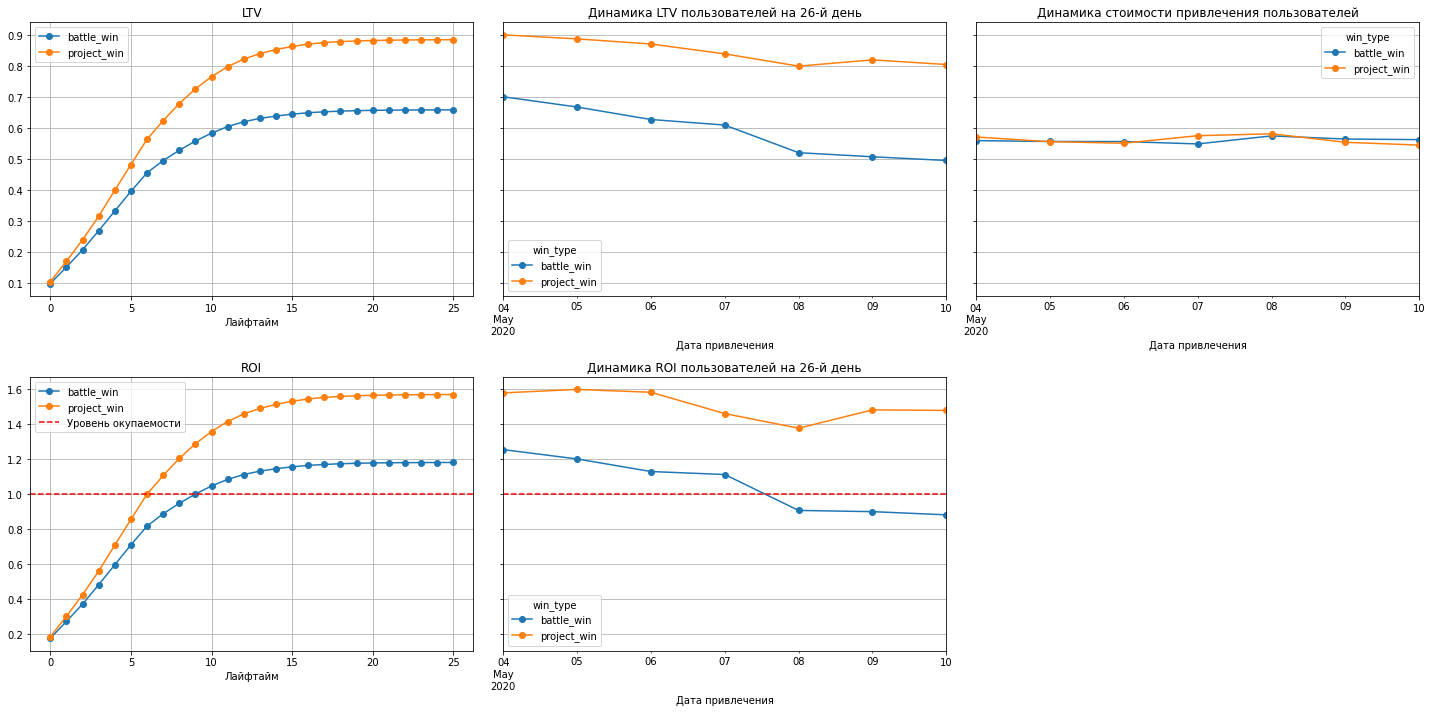

ROI по дням жизненного цикла:


,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
win_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,
battle_win,3951,0.558120,0.174656,0.269984,0.369565,0.480320,0.594599,0.708275,0.815824,0.886296,0.946070,0.999146,1.045461,1.082951,1.111076,1.130281,1.144122,1.154883,1.163168,1.16866,1.172628,1.175199,1.177136,1.178120,1.178850,1.179358,1.179675,1.179802
project_win,1866,0.564238,0.183366,0.299715,0.423576,0.558076,0.707002,0.853868,0.998739,1.105580,1.202914,1.287084,1.356960,1.414337,1.457685,1.488800,1.512668,1.529954,1.543517,1.55236,1.558011,1.561468,1.564194,1.565856,1.567119,1.567917,1.568383,1.568782


In [49]:
field = ['win_type']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = ltv_roi(
    profiles_stage_finish, observation_date, horizon_days, field
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
print('ROI по дням жизненного цикла:')
roi_grouped

LTV группы пользователей, завершивших этап реализацией проекта выше за счет большего среднего количества построек на пользователя;  
CAC для обоих групп сопоставим и со временем меняется незначительно;  
Затраты на маркетинг окупаются:  
- для группы, закончившей этап победой над соперником - на 10 день жизненного цикла:
- для группы, закончившей этап реализацией проекта - на 7 день жизненного цикла:

### Анализ по источникам трафика
<a id="channel_analysis"></a>

**Количество пользователей по источникам трафика**

Строим круговую диаграмму количества привлеченных пользователей по источникам трафика:

source
facebook_ads               2726
instagram_new_adverts      3347
yandex_direct              4817
youtube_channel_reklama    2686
Name: user_id, dtype: int64

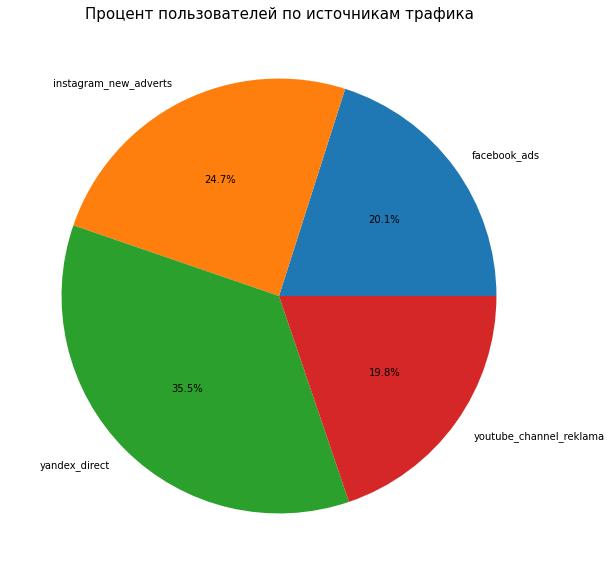

In [50]:
field = 'source'
pie_plot(df_work, field)

Процент пользователей, пришедших из:
- yandex_direct - 35.5% (4817);  
- instagram_new_adverts - 24.7% (3347);
- facebook_ads - 20.1% (2726);
- youtube_channel_reklama - 18.8% (2726);

**Количество пользователей, завершивших первый этап, по источникам трафика**

Строим круговую диаграмму количества привлеченных пользователей, завершивших первый этап, по источникам трафика:

source
facebook_ads               1150
instagram_new_adverts      1466
yandex_direct              2042
youtube_channel_reklama    1159
Name: user_id, dtype: int64

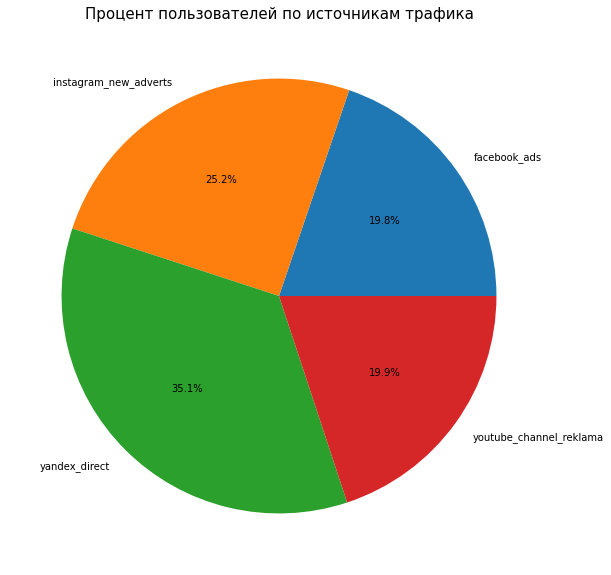

In [51]:
field = 'source'
pie_plot(df_stage_finish, field)

Процент пользователей, пришедших из:
- yandex_direct - 35.1% (2042);  
- instagram_new_adverts - 25.2% (1466);
- youtube_channel_reklama - 19.9% (1159);
- facebook_ads - 19.8% (1150);

Как для всех пользователей, так и для завершивших первый этап:
- наибольший трафик идет по каналу "yandex_direct" - 35.1-35.5%;
- на втором месте - "instagram_new_adverts" - 24.7-25.2%;
- "через facebook_ads" и "youtube_channel_reklama" приходит примерно одинаковое количество пользователей - 19.8-20.1%.

**Типы построек по источникам трафика**

Строим круговые диаграммы построенных зданий по типам для каждого источника трафика:


Источник трафика - youtube_channel_reklama


building_type
assembly_shop      2686
research_center    1478
spaceport          2599
Name: user_id, dtype: int64

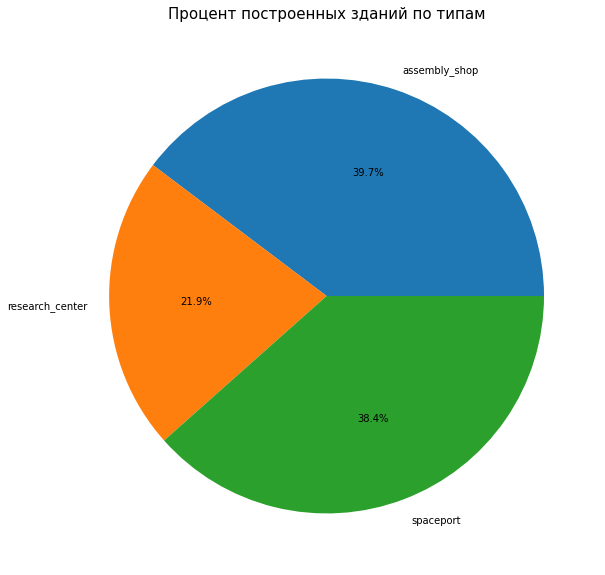

____________________________________________________________________________________________________

Источник трафика - facebook_ads


building_type
assembly_shop      2726
research_center    1577
spaceport          2664
Name: user_id, dtype: int64

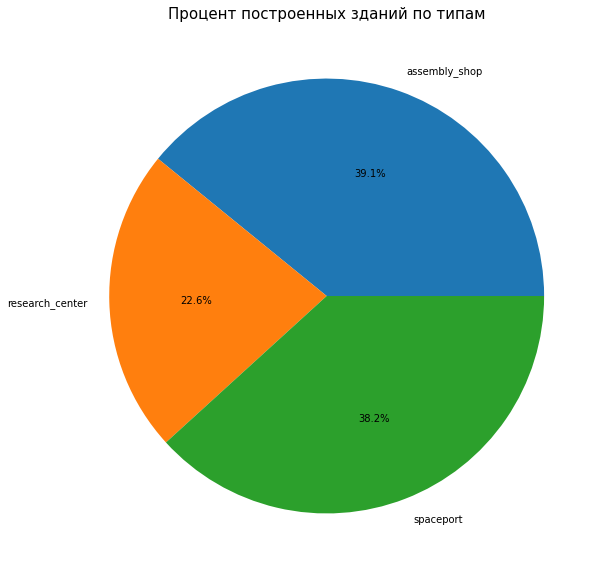

____________________________________________________________________________________________________

Источник трафика - instagram_new_adverts


building_type
assembly_shop      3347
research_center    1906
spaceport          3268
Name: user_id, dtype: int64

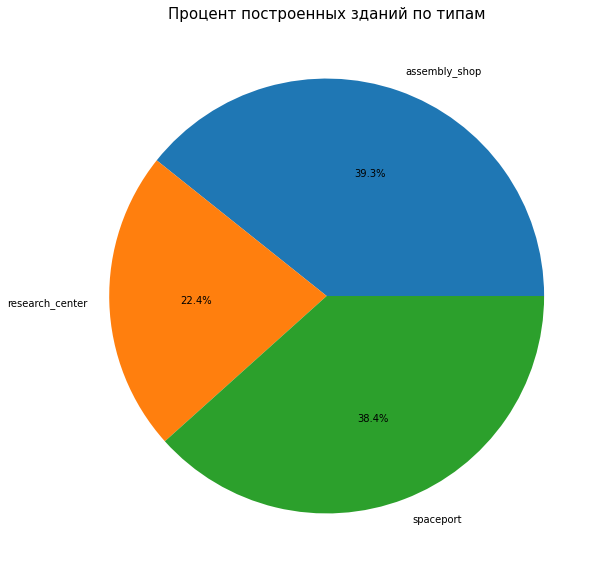

____________________________________________________________________________________________________

Источник трафика - yandex_direct


building_type
assembly_shop      4817
research_center    2710
spaceport          4700
Name: user_id, dtype: int64

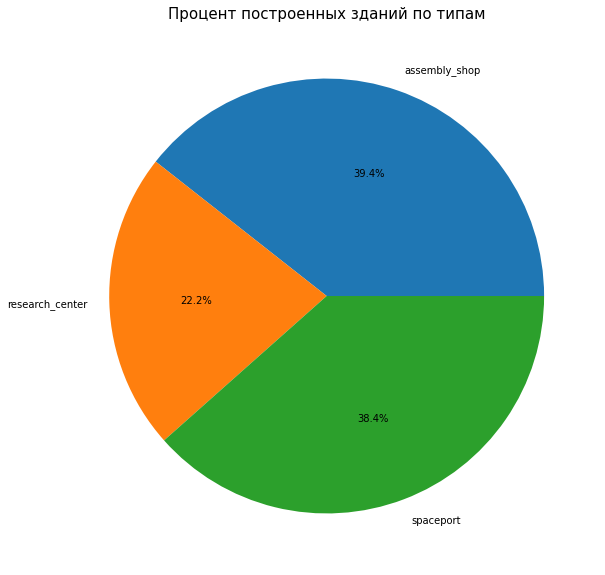

____________________________________________________________________________________________________


In [52]:
field = 'building_type'

for i in df_work['source'].unique():
    print()
    print(f'Источник трафика - {i}')
    pie_plot(df_work.loc[df_work['source'] == i], field)
    print('_' * 100)

По распределению типов построенных зданий все источники трафика схожи:
- "assembly_shop" - 39.1-39.7%;
- "spaceport" - 38.2-38.4%;
- "research_center" - 21.9-22.6%

**Среднее количество зданий на пользователя**

,source,event
0,youtube_channel_reklama,9.299330
1,yandex_direct,9.348557
2,instagram_new_adverts,9.505527
3,facebook_ads,9.585840


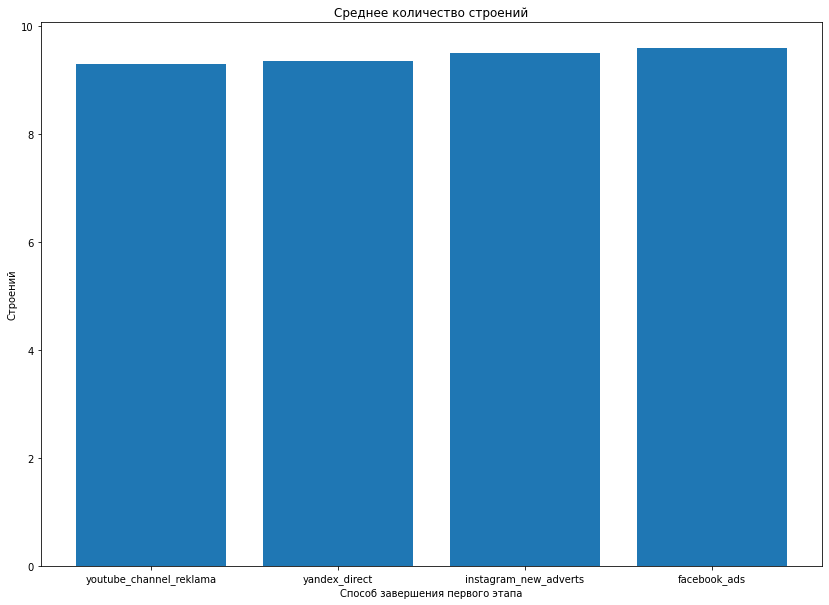

In [53]:
field = ['source']
build_per_user(df_work, field)

Средние значения количества построенных зданий различаются незначительно - 9.3-9.6.

**Метрика DAU**

Рассчитываем DAU для пользователей по источникам трафика:

,source,first_event_date,user_id
0,facebook_ads,2020-05-04,1184
1,facebook_ads,2020-05-05,694
2,facebook_ads,2020-05-06,345
3,facebook_ads,2020-05-07,224
4,facebook_ads,2020-05-08,139
5,facebook_ads,2020-05-09,84
6,facebook_ads,2020-05-10,56
7,instagram_new_adverts,2020-05-04,1452
8,instagram_new_adverts,2020-05-05,796
9,instagram_new_adverts,2020-05-06,472


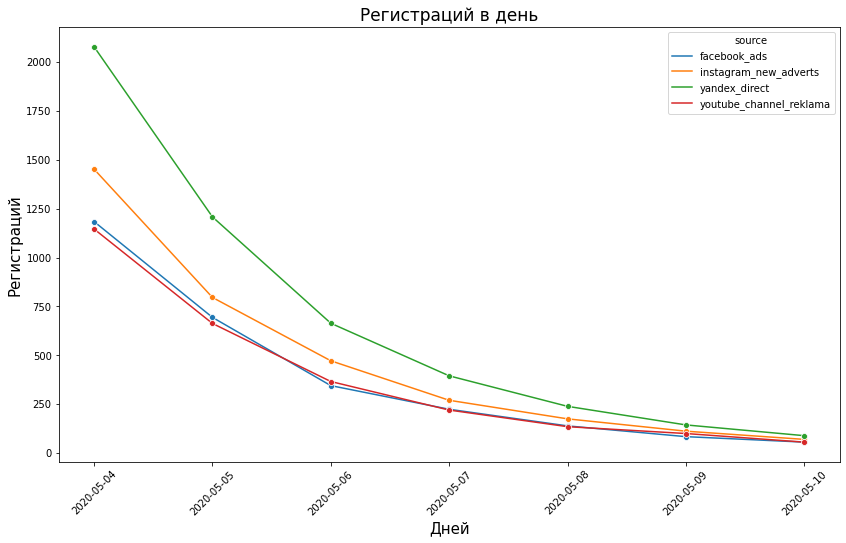

In [54]:
field=['source']
dau(df_work, field)

В первый день количество пользователей, привлеченных по каналу "yandex_direct" значительно превышает, количество пользователей, пришедших по другим источникам: на 626 больше, чем у второго по объему трафика канала "instagram_new_adverts". В течение рассматриваемого периода разница по всем источникам сокращается и в завершающий день достигает 33.

**Затраты на привлечение клиентов по дням**

In [55]:
df_work.groupby(['source', 'first_event_date'])['cost'].first().reset_index()

,source,first_event_date,cost
0,facebook_ads,2020-05-04,935.882786
1,facebook_ads,2020-05-05,548.354480
2,facebook_ads,2020-05-06,260.185754
3,facebook_ads,2020-05-07,177.982200
4,facebook_ads,2020-05-08,111.766796
5,facebook_ads,2020-05-09,68.009276
6,facebook_ads,2020-05-10,38.723350
7,instagram_new_adverts,2020-05-04,943.204717
8,instagram_new_adverts,2020-05-05,502.925451
9,instagram_new_adverts,2020-05-06,313.970984


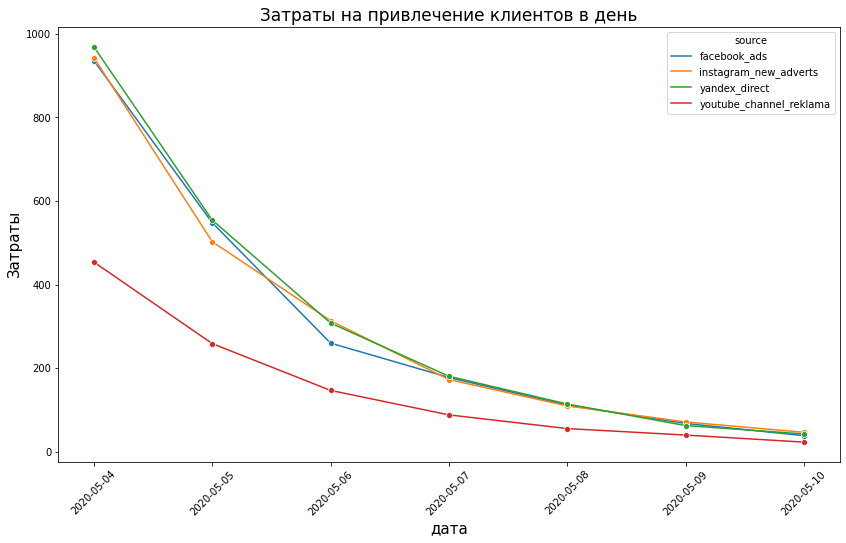

In [56]:
plt.figure(figsize=(14,8))
sns.lineplot(
    x = 'first_event_date',
    y = 'cost',
    hue = 'source',
    data = (
        df_work
            .groupby(['source', 'first_event_date'])['cost'].first()
            .reset_index()
    ),
    marker = 'o'
)
        
plt.title('Затраты на привлечение клиентов в день', fontsize=17)
plt.xlabel('дата', fontsize = 15)
plt.ylabel('Затраты', fontsize = 15)
plt.xticks(rotation=45);

Наименьшие затраты на привлечение пользователей у "youtube_channel_reklama". Затраты по другим источникам сопоставимы: максимальная разница в затратах между ними наблюдается 06.05.2020 - 58.8. При этом, на "youtube_channel_reklama" в этот же день затрачено 113.2 меньше, чем на ближайший по тратам канал - facebook_ads.

**Средняя стоимость клика**

Рассчитываем и строим график средней стоимости клика:

,source,cost_invitation
0,youtube_channel_reklama,0.397662
1,yandex_direct,0.463590
2,instagram_new_adverts,0.645785
3,facebook_ads,0.785365


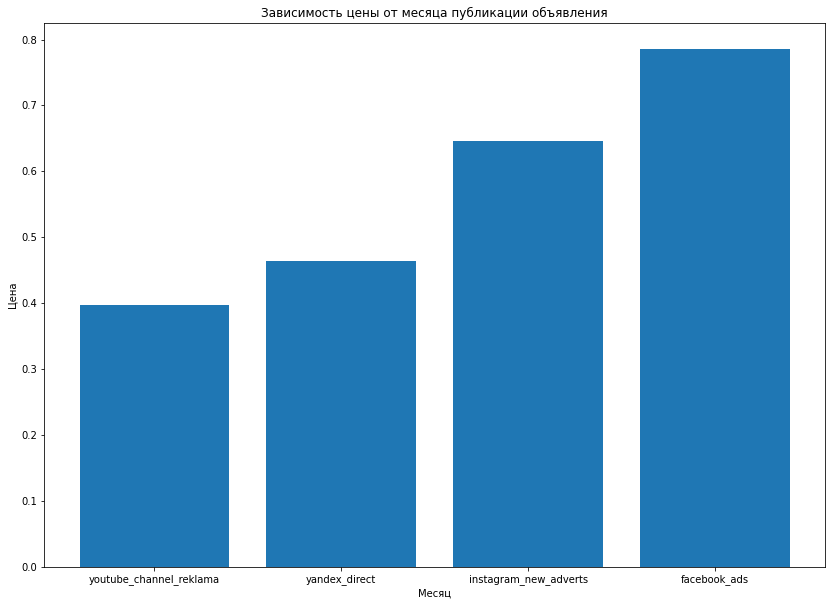

In [57]:
df_mean_cost_invitation = (
    df_work
        .groupby('user_id')
        .agg({'source' : 'first', 'cost_invitation' : 'first'})
        .groupby('source')['cost_invitation']
        .mean()
        .reset_index()
        .sort_values(by='cost_invitation')
        .reset_index(drop=True)
)
display(df_mean_cost_invitation)

plt.figure(figsize=(14,10))
ax = plt.bar(df_mean_cost_invitation['source'], df_mean_cost_invitation['cost_invitation'])
plt.title('Зависимость цены от месяца публикации объявления')
plt.ylabel('Цена')
plt.xlabel('Месяц')
# lmt = (df_mean_cost_invitation['cost_invitation'].max() - df_mean_cost_invitation['cost_invitation'].min())*0.2
# plt.ylim([df_mean_cost_invitation['cost_invitation'].min() - lmt, df_mean_cost_invitation['cost_invitation'].max() + lmt])
plt.show()

Наименьшая средняя стоимость клика у "youtube_channel_reklama" - 0.40. Канал "yandex_direct" идет на втором месте по дешевизне клика (0.46), при том что по данному источнику приходит наибольшее количество пользователей.
Наибольшее среднее стоимости клика у канала "facebook_ads" - 0.78$.

**LTV, CAC, ROI по источникам трафика**

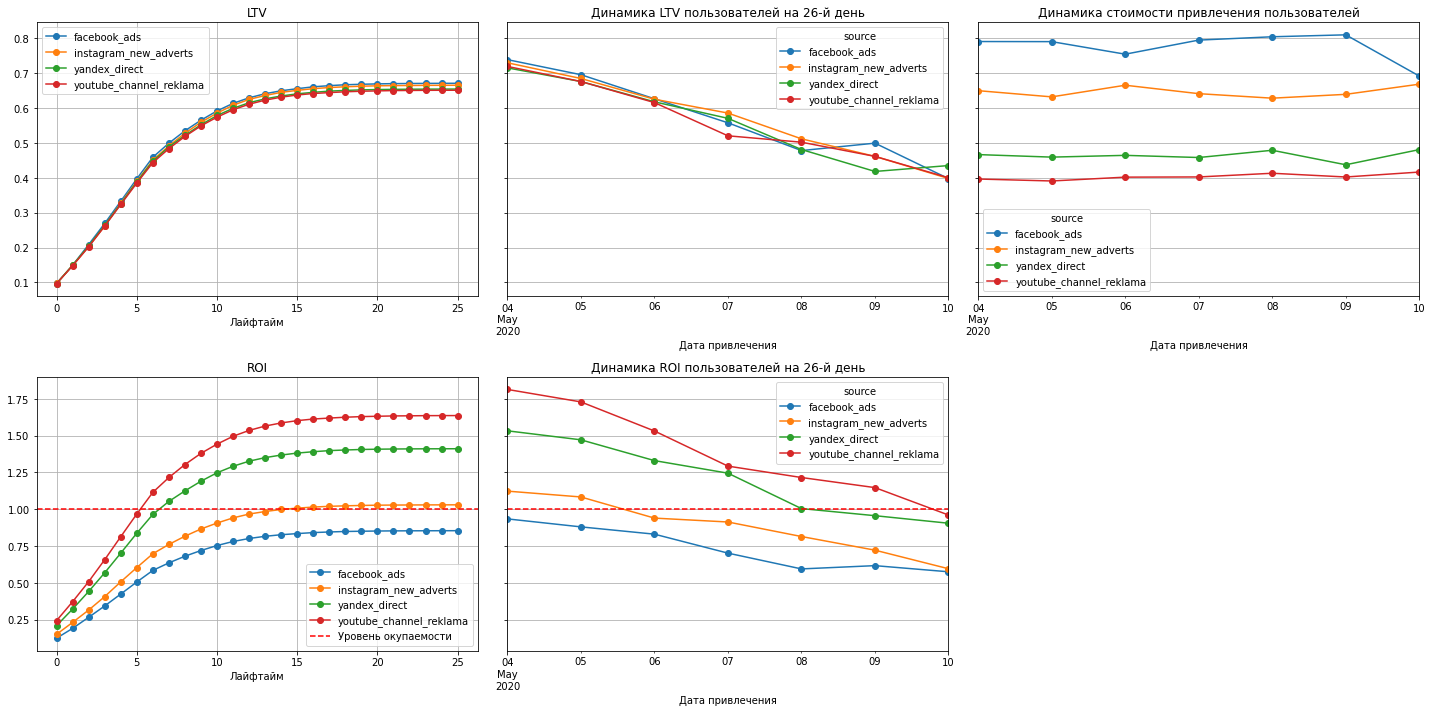

ROI по дням жизненного цикла:


,cohort_size,cac,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
source,,,,,,,,,,,,,,,,,,,,,,,,,,,,
facebook_ads,2726,0.785365,0.123821,0.190326,0.265691,0.342790,0.423615,0.505455,0.584318,0.635521,0.680675,0.719453,0.753228,0.780726,0.801129,0.816006,0.826763,0.834414,0.841182,0.845432,0.848767,0.850435,0.851906,0.852822,0.853345,0.853672,0.853901,0.854130
instagram_new_adverts,3347,0.645785,0.150173,0.231105,0.314822,0.406345,0.506773,0.603606,0.697428,0.760937,0.816737,0.865802,0.906187,0.941196,0.967234,0.984560,0.998422,1.007263,1.014776,1.019796,1.023164,1.025690,1.027504,1.028346,1.028897,1.029447,1.029771,1.030030
yandex_direct,4817,0.463590,0.209049,0.321896,0.441295,0.568436,0.701815,0.837231,0.965062,1.053333,1.124803,1.190568,1.247775,1.292067,1.326674,1.350810,1.368270,1.381687,1.390934,1.398426,1.402751,1.406168,1.408112,1.409303,1.410243,1.410682,1.410995,1.411183
youtube_channel_reklama,2686,0.397662,0.243465,0.371915,0.508295,0.657651,0.813692,0.967832,1.115091,1.215754,1.303834,1.379921,1.442639,1.495854,1.535830,1.565322,1.586621,1.602218,1.613097,1.619651,1.625483,1.629547,1.631906,1.634200,1.635052,1.636100,1.636428,1.636690


In [58]:
field = ['source']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = ltv_roi(
    profiles, observation_date, horizon_days, field
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
print('ROI по дням жизненного цикла:')
roi_grouped

Значения LTV для различных каналов различаются незначительно. Поэтому на разницу в окупаемости источников наибольшее влияние оказывает стоимость привлечения клиента (CAC).  
Наибольшая стоимость привлечения пользователей - по каналу "facebook_ads", что обуславливает неокупаемость данного источника - ROI не поднимается выше единицы.  
Наименьшие CAC и, соответственно, наибольшее ROI (1.64 на последний день горизонта анализа) у канала "youtube_channel_reklama". Но при этом по данному каналу приходит наименьшее количество пользователей.  
Источник, по которому приходит наибольшее количество пользователей - "yandex_direct" - имеет второй по величине ROI на последний день горизонта анализа - 1.41.  
В меньшей степени окупается маркетинговая компания для источника "instagram_new_adverts" - ROI на последний день горизонта анализа - 1.03.

**Вывод:**  
1.	Почти половина (49.5%) зарегистрировавшихся пользователей не завершили первый этап. Из завершивших 67.9% сделали это посредством победы над соперником, а 32.1% - реализацией проекта.  
2.	Оптимальное событие для начала показа рекламы - вторая постройка.  
3.	В целом затраты на привлечение окупаются на 10 день жизненного цикла.  
4.	Пользователи, завершившие первый этап реализацией проекта, в среднем строят больше зданий - 12.6 против 9.4 у одолевших соперника.  
5.	Пользователи, завершившие первый этап реализацией проекта, в среднем тратят больше времени на завершение уровня - 13.4 дня против 11.0 дней у одолевших соперника.  
6.	Пользователи, завершившие первый этап реализацией проекта, чаще строят здания типа "космопорт" ("spaceport"), нежели пользователи, победившие соперника.  
7.	Затраты на привлечение быстрее окупаются пользователями, завершившим первый этап реализацией проекта, - за 7 дней против 10 дней у группы пользователей, одолевших соперника.  
8.	Затраты на привлечение пользователей по источникам окупаются:  
- youtube_channel_reklama – на 6 день;  
- yandex_direct – на 7 день;  
- instagram_new_adverts – на 15 день;  
- facebook_ads – не окупается;  
9.	Наиболее перспективный источник трафика – по нему приходят 35.5% пользователей, при этом стоимость привлечения клиентов относительно невелика, а количество построек сопоставимо с другими каналами привлечения.

### Оптимальные схемы показа рекламы
<a id="schemas"></a>

Показ рекламы, запущенной слишком рано, пока игрок не втянулся в игру, может привести к снижению лояльности пользователя. Запоздание в старте показа рекламы приведет к тому, что маркетинговая компания не окупится. Оптимальное событие для старта - наиболее позднее событие, при начале показа рекламы с которого маркетинговая компания окупается.  
Строим ROI в последние день горизонта событий в зависимости от порядкового номера постройки, с которого стартует показ рекламы:

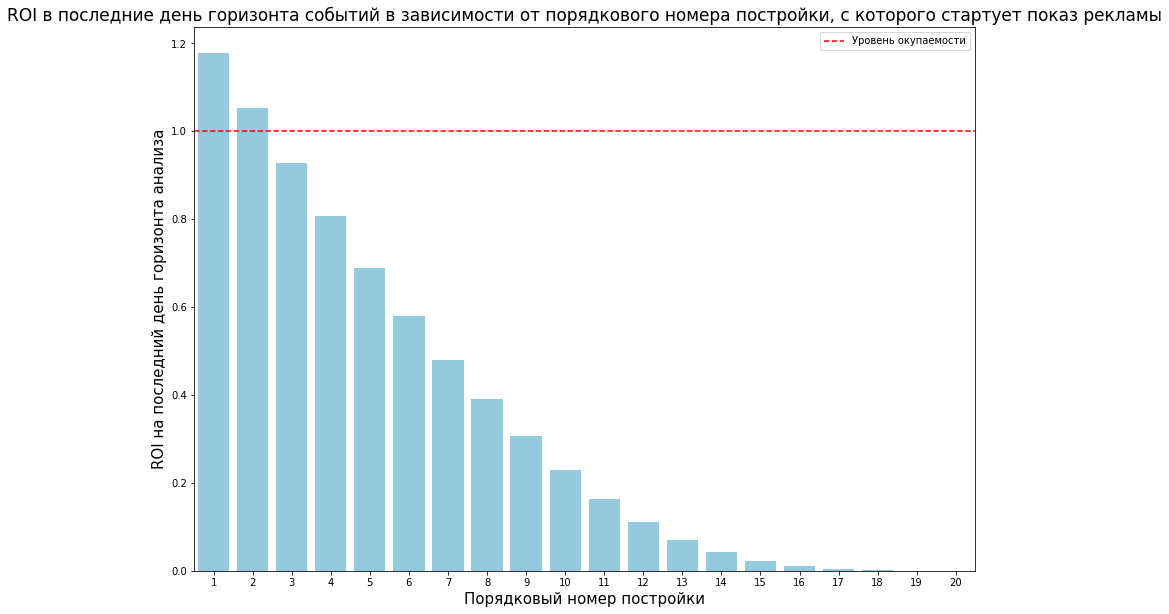

In [59]:
event_iteration(profiles, observation_date, horizon_days)

Оптимальное событие для начала показа рекламы - вторая постройка.

**Оптимальное типы зданий для показа рекламы**

Определяем, возможно ли исключить здания какого-либо типа из схемы показа рекламы. Если таковой тип имеется, то показываться реклама должна будет не на странице меню выбора постройки, а после совершения постройки.  
Рассчитываем LTV, CAC, ROI при условии, что стоимость показа рекламы при строительстве здания какого-либо типа, равна нулю:

Метрики без учета дохода от рекламы для зданий типа "assembly_shop":


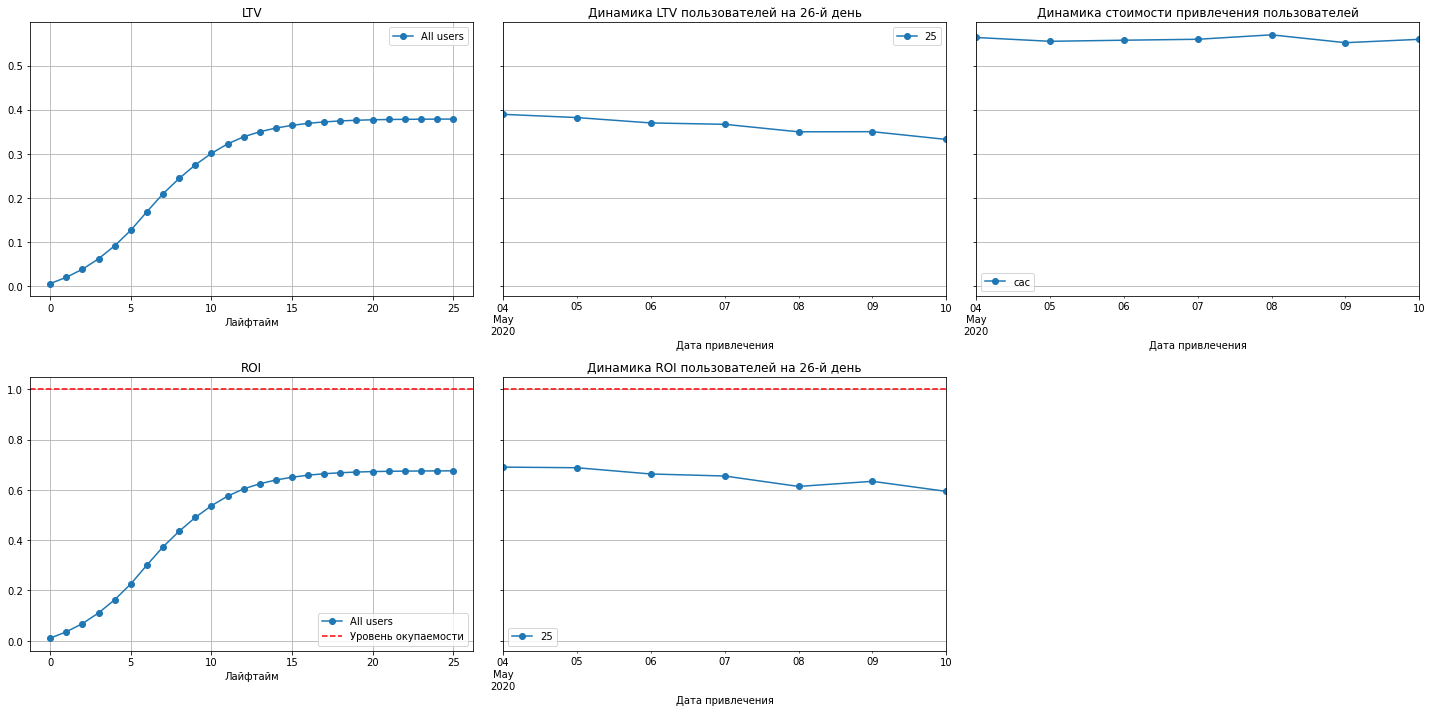

____________________________________________________________________________________________________

Метрики без учета дохода от рекламы для зданий типа "spaceport":


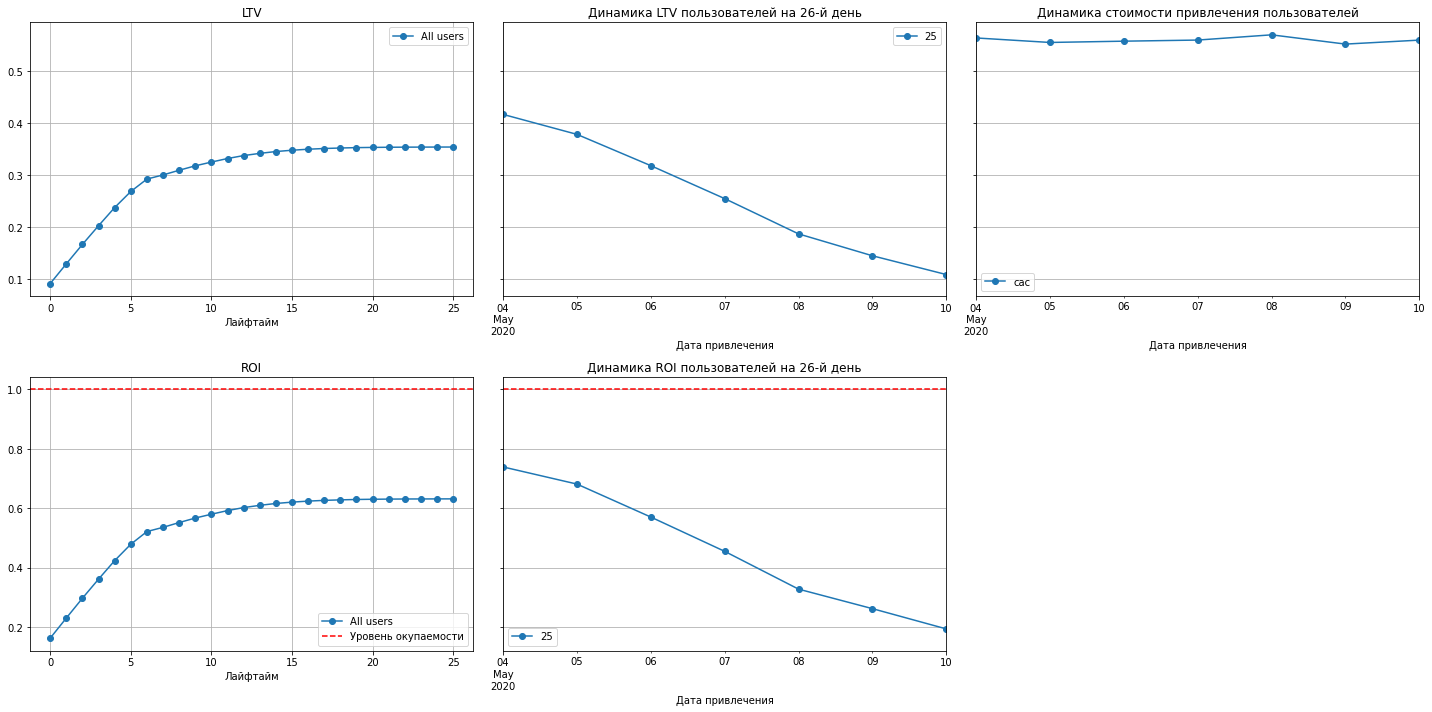

____________________________________________________________________________________________________

Метрики без учета дохода от рекламы для зданий типа "research_center":


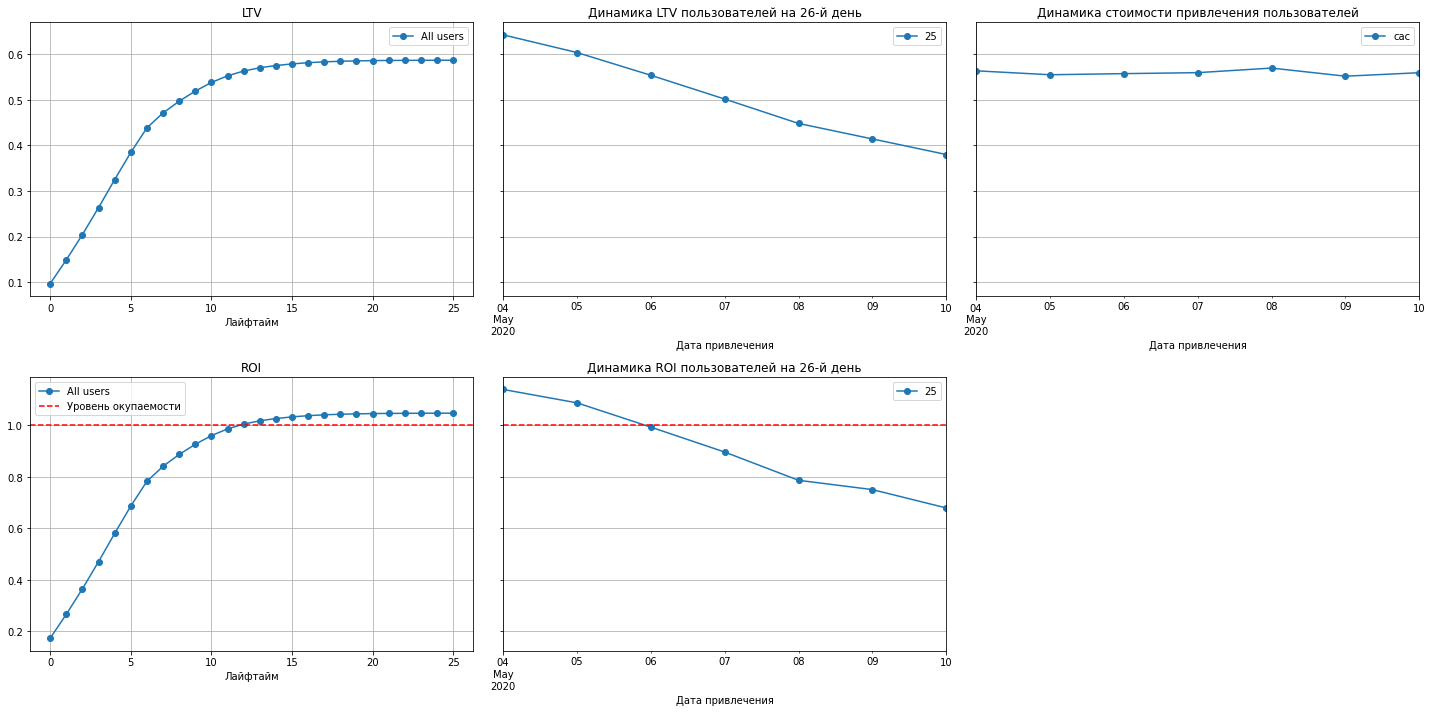

____________________________________________________________________________________________________



In [60]:
field = []
for i in df_work.loc[df_work['event'] == 'building']['building_type'].unique().tolist():
    ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = ltv_roi(profiles, observation_date, horizon_days, field, i)
    print(f'Метрики без учета дохода от рекламы для зданий типа "{i}":')
    plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
    print('_'*100)
    print()

При исключении показа рекламы при строительстве зданий типа "исследовательский центр" ("research_center"), маркетингавая компания окупается.

**Вывод:**  
Определены 2 схемы показа рекламы, позволяющие окупить маркетинговую компанию и не перегружающие пользователя рекламой:  
1. Показ рекламы при втором открытии меню строительства зданий.  
2. Показ рекламы после строительства каждого здания типа сборочный цех ("assembly_shop") и assembly_shop ("spaceport").  

## Проверка гипотез
<a id="hypotheses"></a>

Используем метод для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам - ttest_ind.  
Поскольку тест двусторонний, целесообразно выбрать alpha = 0.05, так как в таком случае на каждую сторону распределения придется 0.025. Уменьшение уровня статистической значимости увеличит риск возникновения ошибки второго рода, а увеличение - первого.

**Гипотеза H0 - время завершения первого уровня победой над соперником равно времени завершения первого уровня реализацией проекта.  
Гипотеза H1 - время завершения первого уровня победой над соперником не равно времени завершения первого уровня реализацией проекта.**

Собираем данные по пользователям, завершивших первый уровень победой над соперником:

In [61]:
df_battle_time = (
    df_work
    .loc[(df_work['win_type'] == 'battle_win') & (df_work['event'] == 'finished_stage_1'), ['user_id', 'stage_time']]
)

Собираем данные по пользователям, завершивших первый уровень реализацией проекта:

In [62]:
df_project_time = (
    df_work
    .loc[(df_work['win_type'] == 'project_win') & (df_work['event'] == 'finished_stage_1'), ['user_id', 'stage_time']]
)

Задаем критический уровень статистической значимости:

In [63]:
alpha = .05

Сравниваем дисперсии выборок:

In [64]:
var_finish_stage_time = levene(df_battle_time['stage_time'], df_project_time['stage_time'])
if var_finish_stage_time.pvalue < alpha:
    print('Критерий Левена ({}) предполагает, что выборки не имеют одинаковой дисперсии.'.format(var_finish_stage_time.pvalue))
else:
    print('Критерий Левена ({}) предполагает, что выборки имеют одинаковую дисперсию.'.format(var_finish_stage_time.pvalue))

Критерий Левена (3.520809068858293e-10) предполагает, что выборки не имеют одинаковой дисперсии.


Сравниваем выборки (t-тест):

In [65]:
result_finish_stage_time = st.ttest_ind(df_battle_time['stage_time'], df_project_time['stage_time'], equal_var = False)
print('p-значение:', result_finish_stage_time.pvalue)

p-значение: 6.570466755643636e-105


Проверяем нулевую гипотезу. Если она не подтверждается, сразу определяем какое среднее больше:

In [66]:
if result_finish_stage_time.pvalue < alpha and df_battle_time['stage_time'].mean() < df_project_time['stage_time'].mean():
    print('Отвергаем нулевую гипотезу: с высокой вероятностью время завершения первого уровня победой над соперником меньше\n времени завершения первого уровня реализацией проекта.')
elif result_finish_stage_time.pvalue < alpha and df_battle_time['stage_time'].mean() > df_project_time['stage_time'].mean():
    print('Отвергаем нулевую гипотезу: с высокой вероятностью время завершения первого уровня победой над соперником больше\n времени завершения первого уровня реализацией проекта..')
else:
    print('Не отвергаем нулевую гипотезу.')

Отвергаем нулевую гипотезу: с высокой вероятностью время завершения первого уровня победой над соперником меньше
 времени завершения первого уровня реализацией проекта.


**Гипотеза H0 - количество построек у пользователей, завершивших первый этап победой над соперником, равно количеству построек у пользователей, завершивших первый этап реализацией проекта.  
Гипотеза H1 - количество построек у пользователей, завершивших первый этап победой над соперником, не равно количеству построек у пользователей, завершивших первый этап реализацией проекта.**

Собираем данные по пользователям, завершивших первый уровень победой над соперником:

In [67]:
df_battle_build = (
    df_work
    .loc[(df_work['win_type'] == 'battle_win') & (df_work['event'] == 'building')]
    .groupby('user_id')['event'].count()
    .reset_index()
)

Собираем данные по пользователям, завершивших первый уровень реализацией проекта:

In [68]:
df_project_build = (
    df_work
    .loc[(df_work['win_type'] == 'project_win') & (df_work['event'] == 'building')]
    .groupby('user_id')['event'].count()
    .reset_index()
)

Задаем критический уровень статистической значимости:

In [69]:
alpha = .05

Сравниваем дисперсии выборок:

In [70]:
var_finish_stage_build = levene(df_battle_build['event'], df_project_build['event'])
if var_finish_stage_build.pvalue < alpha:
    print('Критерий Левена ({}) предполагает, что выборки не имеют одинаковой дисперсии.'.format(var_finish_stage_build.pvalue))
else:
    print('Критерий Левена ({}) предполагает, что выборки имеют одинаковую дисперсию.'.format(var_finish_stage_build.pvalue))

Критерий Левена (9.599913255790728e-40) предполагает, что выборки не имеют одинаковой дисперсии.


Сравниваем выборки (t-тест):

In [71]:
result_finish_stage_build = st.ttest_ind(df_battle_build['event'], df_project_build['event'], equal_var = False)
print('p-значение:', result_finish_stage_build.pvalue)

p-значение: 0.0


Проверяем нулевую гипотезу. Если она не подтверждается, сразу определяем какое среднее больше:

In [72]:
if result_finish_stage_build.pvalue < alpha and df_battle_build['event'].mean() < df_project_build['event'].mean():
    print('Отвергаем нулевую гипотезу: с высокой вероятностью количество построек на пользователя, завершившего первый этап\n победой над соперником, меньше количества построек на пользователя, завершившего первый этап реализацией проекта.')
elif result_finish_stage_build.pvalue < alpha and df_battle_build['event'].mean() > df_project_build['event'].mean():
    print('Отвергаем нулевую гипотезу: с высокой вероятностью количество построек на пользователя, завершившего первый этап\n победой над соперником, больше количества построек на пользователя, завершившего первый этап реализацией проекта.')
else:
    print('Не отвергаем нулевую гипотезу.')

Отвергаем нулевую гипотезу: с высокой вероятностью количество построек на пользователя, завершившего первый этап
 победой над соперником, меньше количества построек на пользователя, завершившего первый этап реализацией проекта.


**Вывод:**  
1. Гипотезу H0 о равенстве количества построек у пользователей, завершивших первый этап победой над соперником, и у пользователей, завершивших первый этап реализацией проекта, отвергаем. С высокой вероятностью количество построек на пользователя, завершившего первый этап победой над соперником, меньше количества построек на пользователя, завершившего первый этап реализацией проекта.  
2. Гипотеза H0 о равенстве времени, затраченного на завершения первого уровня победой над соперником, и времени, затраченного на завершение первого уровня реализацией проекта, отвергаем. С высокой вероятностью время завершения первого уровня победой над соперником меньше времени завершения первого уровня реализацией проекта. 

## Общий вывод
<a id="final"></a>

**Общая информация**  
Исходные данные представлены тремя датасетами, в которых содержатся информация о:  
 - затратах на пивлечение пользователей за период 04.05.2020-10.05.2020;  
 - событиях для каждого пользователя (135640 событий);  
 - источниках трафика.  

**Предобработка данных**  
1. Удалены дубликаты.  
2. Оптимизация типов данных: даты приведены к типу "datetime64".  
3. Устранено смещение по дате в данных о затратах на маркетинг.  

**Исследовательский анализ данных**  
1.	Почти половина (49.5%) зарегистрировавшихся пользователей не завершили первый этап. Из завершивших 67.9% сделали это посредством победы над соперником, а 32.1% - реализацией проекта.  
2.	В целом затраты на привлечение окупаются на 10 день жизненного цикла.  
3.	Пользователи, завершившие первый этап реализацией проекта, в среднем строят больше зданий - 12.6 против 9.4 у одолевших соперника.  
4.	Пользователи, завершившие первый этап реализацией проекта, в среднем тратят больше времени на завершение уровня - 13.4 дня против 11.0 дней у одолевших соперника.  
5.	Пользователи, завершившие первый этап реализацией проекта, чаще строят здания типа "космопорт" ("spaceport"), нежели пользователи, победившие соперника.  
6.	Затраты на привлечение быстрее окупаются пользователями, завершившим первый этап реализацией проекта, - за 7 дней против 10 дней у группы пользователей, одолевших соперника.  
7.	Затраты на привлечение пользователей по источникам окупаются:  
- youtube_channel_reklama – на 6 день;  
- yandex_direct – на 7 день;  
- instagram_new_adverts – на 15 день;  
- facebook_ads – не окупается;  
8.	Наиболее перспективный источник трафика – по нему приходят 35.5% пользователей, при этом стоимость привлечения клиентов относительно невелика, а количество построек сопоставимо с другими каналами привлечения.  
9. Определены 2 схемы показа рекламы, позволяющие окупить маркетинговую компанию и не перегружающие пользователя рекламой:  
- показ рекламы при втором открытии меню строительства зданий.  
- показ рекламы после строительства каждого здания типа "сборочный цех" ("assembly_shop") и "космопорт" ("spaceport").  

**Проверка гипотез**  
1. Гипотезу H0 о равенстве количества построек у пользователей, завершивших первый этап победой над соперником, и у пользователей, завершивших первый этап реализацией проекта, отвергаем. С высокой вероятностью количество построек на пользователя, завершившего первый этап победой над соперником, меньше количества построек на пользователя, завершившего первый этап реализацией проекта.  
2. Гипотеза H0 о равенстве времени, затраченного на завершения первого уровня победой над соперником, и времени, затраченного на завершение первого уровня реализацией проекта, отвергаем. С высокой вероятностью время завершения первого уровня победой над соперником меньше времени завершения первого уровня реализацией проекта. 

**Рекомендации**
<a id="recom"></a>

1. Увеличить финансирование привлечения клиентов по каналам с высокой окупаемостью - youtube_channel_reklama и yandex_direct - за счет снижения затрат на неокупающийся источник facebook_ads.  
2. Показ рекламы рекомендуется начать, либо со второго открытия меню строительства, либо после постройки зданий типа "сборочный цех" ("assembly_shop") и "космопорт" ("spaceport"). Второй вариант предпочтительней, так как позволяет снять рекламную нагрузку с пользователя на весь период жизненного цикла.
3. По возможности стимулировать пользователей к прохождению игры путем реализации проекта, 